<a href="https://colab.research.google.com/github/israellmorais/ReconhecimentodePadroes/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Arvores de Decisão

In [139]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

iris = load_iris()
X, y = iris.data[:,2:], iris.target

In [140]:
def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

In [141]:
def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores


In [142]:
def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.caracteristica = 0
    def fit(self, X, y):
        self.valor = np.mean(X[:,self.caracteristica])
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

def ArvoreAula(X,y):

    modelo = Arvore()
    modelo.fit(X,y)
    ypred = modelo.predict(X)
    accuracy_score(y, ypred), (ypred == y)

    return accuracy_score(y, ypred)

In [143]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y,titulo):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
    plt.title(titulo)
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()


#Heuristica Nova

In [144]:
def melhorValorMaxStd(x, y):
    result = None
    menorImpureza = float('inf')
    
    valor = np.max(x)-np.std(x)
    
    while True:
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
     
    return result, menorImpureza


In [145]:

def melhorCaracteristicaAlt(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValorMaxStd(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]
    print(melhorCaracteristicaAlt(X,y))

In [146]:
class ArvoreAlt(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristicaAlt(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = ArvoreAlt()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = ArvoreAlt()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

def ArvoreAlterada(X,y):
    modelo = ArvoreAlt()
    scores = cross_validate(ArvoreAlt(), X, y)
       
    return np.mean(scores['test_score'])


#Scikit Learn

In [147]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score

def sklearn(criterio, X, y):
    sklearn_aux = DecisionTreeClassifier(criterion='gini')
    scores = cross_validate(sklearn_aux, X, y)
    return np.mean(scores['test_score'])



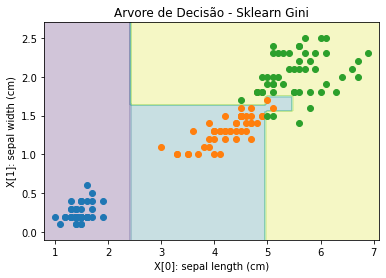

In [148]:
from sklearn.linear_model import LogisticRegression
plotDecisao(DecisionTreeClassifier(criterion='gini'), X, y,"Arvore de Decisão - Sklearn Gini")


In [149]:
def imprimirHeuristicas(X,y):
    arvore_aula = ArvoreAula(X,y)
    arvore_heuristica = ArvoreAlterada(X,y)
    arvore_sklearn_gini = sklearn('gini',X,y)
    arvore_sklearn_entropy = sklearn('entropy',X,y)

    print('\nArvore de Decisão - Aula = %.2f' % (arvore_aula*100), '%')
    print('Arvore de Decisão - Heuristica = %.2f' % (arvore_heuristica*100), '%')
    print('Arvore de Decisão - Sklearn Gini = %.2f' % (arvore_sklearn_gini*100), '%')
    print('Arvore de Decisão - Sklearn Entropy = %.2f' % (arvore_sklearn_entropy*100), '%')

In [150]:
print("Base Iris")
imprimirHeuristicas(X,y)

Base Iris

Arvore de Decisão - Aula = 95.33 %
Arvore de Decisão - Heuristica = 96.67 %
Arvore de Decisão - Sklearn Gini = 94.67 %
Arvore de Decisão - Sklearn Entropy = 95.33 %


In [151]:
def imprimirGraficos(X,y):
    plotDecisao(Arvore(), X, y,"Arvore de Decisão - Aula")
    print('\nArvore de Decisão - Aula = %.2f' % (arvore_aula*100), '%')
    plotDecisao(ArvoreAlt(), X, y,"Arvore de Decisão - Heuristica Nova")
    print('Arvore de Decisão - Heuristica = %.2f' % (arvore_heuristica*100), '%')
    plotDecisao(DecisionTreeClassifier(criterion='gini'), X, y,"Arvore de Decisão - Sklearn Gini")
    print('Arvore de Decisão - Sklearn Gini = %.2f' % (arvore_sklearn_gini*100), '%')
    plotDecisao(DecisionTreeClassifier(criterion='entropy'), X, y,"Arvore de Decisão - Sklearn Entropy")
    print('Arvore de Decisão - Sklearn Entropy = %.2f' % (arvore_sklearn_entropy*100), '%')


Base Iris

Arvore de Decisão - Aula = 95.33 %
Arvore de Decisão - Heuristica = 96.67 %
Arvore de Decisão - Sklearn Gini = 95.33 %
Arvore de Decisão - Sklearn Entropy = 95.33 %


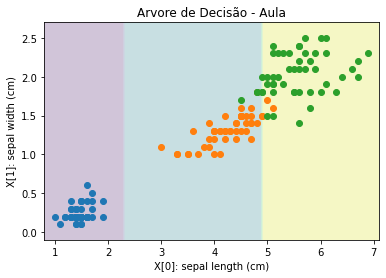


Arvore de Decisão - Aula = 95.33 %


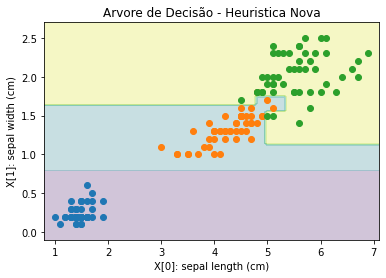

Arvore de Decisão - Heuristica = 96.67 %


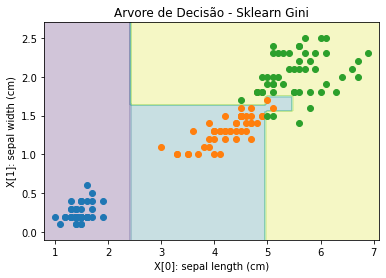

Arvore de Decisão - Sklearn Gini = 95.33 %


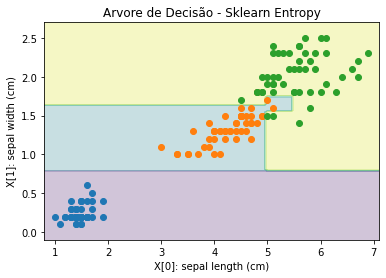

Arvore de Decisão - Sklearn Entropy = 95.33 %


In [152]:
print("Base Iris")
imprimirHeuristicas(X,y)
imprimirGraficos(X,y)

#Base Breast Cancer

In [153]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()

Xc, yc = breast_cancer.data, breast_cancer.target

print('**********BREAST CANCER**********')
print('Acurácia')
imprimirHeuristicas(Xc,yc)

**********BREAST CANCER**********
Acurácia

Arvore de Decisão - Aula = 95.78 %
Arvore de Decisão - Heuristica = 91.92 %
Arvore de Decisão - Sklearn Gini = 92.44 %
Arvore de Decisão - Sklearn Entropy = 92.26 %


#Base Wine

In [154]:
from sklearn.datasets import load_wine

wine = load_wine()

X, y = wine.data, wine.target

print('**********WINE**********')
print('Acurácia:')
imprimirHeuristicas(X,y)

**********WINE**********
Acurácia:

Arvore de Decisão - Aula = 89.33 %
Arvore de Decisão - Heuristica = 85.97 %
Arvore de Decisão - Sklearn Gini = 87.10 %
Arvore de Decisão - Sklearn Entropy = 88.21 %


#Base de Dados de Imunoterapia

In [155]:
url =  'https://archive.ics.uci.edu/ml/machine-learning-databases/00428/Immunotherapy.xlsx'
base = pd.read_excel(url) 
X, y = base.iloc[:,:-1].values, base.iloc[:,-1].values

print('**********Imunoterapia**********')
print('Acurácia:')
imprimirHeuristicas(X,y)

**********Imunoterapia**********
Acurácia:

Arvore de Decisão - Aula = 78.89 %
Arvore de Decisão - Heuristica = 76.67 %
Arvore de Decisão - Sklearn Gini = 85.56 %
Arvore de Decisão - Sklearn Entropy = 83.33 %


#Conclusão

As arvores de decisão se mostram uma abordagem muito utilizada para a resolução de problemas de classificação. As decições se dão com base no caminhamento do nó raiz até o nó folha. Nos vídeos da aula, a melhor característica era obtida pela média entre o máximo e mínimo valor. Já na heuristica desenvolvida, a melhor característica vou definida de acordo com o máximo valor menor o desvio padrão das amostras. As árvores de decisão do Sklearn possuem uma variante que são o índice gini que seleciona aleatoriamente dois itens de uma população e a entropia é usada para estimar a aleatoriedade da variável a prever. Olhando os resultados e as bases utilizadas, a acurácia foi bem próxima entre todas as heurísticas, sendo que obteram valores superiores a 90% nas bases iris e breast câncer.